In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [137]:
# Take sample
# solver1D_from = lambda i: readwritedatafiles.read_data_file(
  # f"tung_conduit1_{i}.pkl")
# solver2D_from = lambda i, j: readwritedatafiles.read_data_file(
  # f"tung_atm{j}_{i}.pkl")
solver1D_from = lambda i: readwritedatafiles.read_data_file(
  f"featuretest_conduit1_{i}.pkl")
solver = solver1D_from(1)

In [ ]:
solver
''' KXRCF detector? '''
# Relative inflow boundary integration, interior

# Relative inflow boundary integration, neighbour

# Abs diff

# Interior integration

# Relative inflow boundary measure

# Mesh size scale
dx = solver.mesh.node_coords[1] - solver.mesh.node_coords[0]
k = solver.order
sc = dx ** (0.5*(k+1))

In [87]:
U = solver.state_coeffs
U_elem_faces = helpers.evaluate_state(U, lll.basis_val_elem_faces, 
  skip_interp=solver.basis.skip_interp)
nq_elem = lll.quad_wts_elem.shape[0]
U_elem = U_elem_faces[:, :nq_elem, :]
U_face = U_elem_faces[:, nq_elem:, :]
U_bar = lambda U: helpers.get_element_mean(U_elem, lll.quad_wts_elem, lll.djac_elems, lll.elem_vols)
# U_bar(solver.state_coeffs[0:2,:,:])


In [59]:
# Inverse mass matrix
solver.elem_helpers.iMM_elems[0,]

array([[ 0.9  , -0.15 ,  0.3  ],
       [-0.15 ,  0.225, -0.15 ],
       [ 0.3  , -0.15 ,  0.9  ]])

In [86]:
physics = solver.physics
physics.state_indices
# physics.NUM_STATE_VARS, physics.NDIMS

{'pDensityA': 0,
 'pDensityWv': 1,
 'pDensityM': 2,
 'XMomentum': 3,
 'Energy': 4,
 'pDensityWt': 5,
 'pDensityC': 6,
 'pDensityFm': 7}

(False, array([78, 79, 80, 81, 82, 83], dtype=int64), 1.360664577402258e-05)

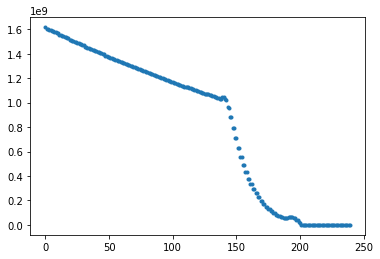

In [252]:
solver = solver1D_from(1)

from numerics.limiting.hwenolimiter import HWENO
# Simulate limiter
lll = HWENO(0)
lll.precompute_helpers(solver)
# ll.get_nonlinearwts(solver.order, p, [1e-3, 1-2e-3, 1e-3]], basis_phys_grad, quad_wts, 
			# vols, djacs):
# Package locals
from numerics.limiting.tools import minmod_shock_indicator
class HWENOLoc:
  pass
hwl = HWENOLoc()
lll.shock_indicator = minmod_shock_indicator
lll.tvb_param = 1e-6

Vc = np.einsum('elij, elj -> eli', lll.left_eigen, U)
shock_indicated = lll.shock_indicator(lll, solver, U)
shock_indicated



# Try limiter
U0 = solver.state_coeffs.copy()
Uc = U0.copy()
# Modifies in-place
Uc = lll.limit_solution(solver, Uc)

# Plot solution
# plt.plot(Uc[...,0].ravel(), '^')
plt.plot(solver.state_coeffs[...,4].ravel(), '.')


np.all(Uc == U0), shock_indicated, np.linalg.norm((Uc-U0)[...,0].ravel())

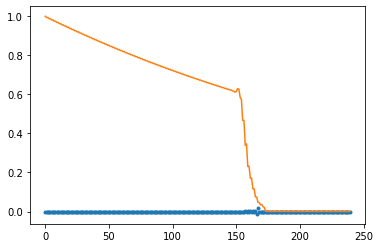

In [213]:
plt.plot((Uc/U0-1)[...,4].ravel(), '.')
plt.plot(U0[...,4].ravel()/U0.max())
# plt.plot(Uc[...,4].ravel(), '.')
# U0.max()

array([79, 80, 81], dtype=int64)

In [112]:
# Set example coefficients
U = solver.state_coeffs
U_elem_faces = helpers.evaluate_state(U, lll.basis_val_elem_faces, 
  skip_interp=solver.basis.skip_interp)
nq_elem = lll.quad_wts_elem.shape[0]
U_elem = U_elem_faces[:, :nq_elem, :]
U_face = U_elem_faces[:, nq_elem:, :]
elt_mean_from = lambda U: helpers.get_element_mean(U_elem, lll.quad_wts_elem, lll.djac_elems, lll.elem_vols)
# U_bar(solver.state_coeffs[0:2,:,:])

get_eigenvector_function = getattr(physics, 
				"get_conv_eigenvectors", None)
physics.get_conv_eigenvectors(elt_mean_from(U))



(array([[[[ 5.859295709613514e+05, -5.746504144254588e+05,
           -5.154244565473484e-03, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [-3.708999391844238e+05,  3.596207826485313e+05,
            5.154244565473484e-03, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [-2.150296317769275e+05,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          ...,
          [ 0.000000000000000e+00,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  1.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [ 0.000000000000000e+00,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  0.000000000000000e+00,
            1.000000000000000e+00,  0.000000000000000e+00],
          [ 0.000000000000000e+00,  0.000000000000000e+00,
           

(array([[[[ 5.859295709613514e+05, -5.746504144254588e+05,
           -5.154244565473484e-03, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [-3.708999391844238e+05,  3.596207826485313e+05,
            5.154244565473484e-03, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [-2.150296317769275e+05,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  0.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          ...,
          [ 0.000000000000000e+00,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  1.000000000000000e+00,
            0.000000000000000e+00,  0.000000000000000e+00],
          [ 0.000000000000000e+00,  0.000000000000000e+00,
            0.000000000000000e+00, ...,  0.000000000000000e+00,
            1.000000000000000e+00,  0.000000000000000e+00],
          [ 0.000000000000000e+00,  0.000000000000000e+00,
           

In [100]:
solver.physics.get_essential_eigenvectors_L(U).shape
R = solver.physics.get_eigenvectors_R(U)
L  =solver.physics.get_eigenvectors_L(U)
T = R@L
T.shape, R.shape
np.linalg.norm(
  np.linalg.norm(T-np.eye(8), ord="fro", axis=(-1,-2))
)

3.026882218292771e-07

In [64]:
# Constant 1^T * M * 1 as int 1 ^2 d\mu = mu(elem)
invM = solver.elem_helpers.iMM_elems[0,]
M = np.linalg.inv(invM)
b = 

In [50]:
U_elem.shape, U_face.shape, U_elem_faces.shape

((120, 3, 7), (120, 2, 7), (120, 5, 7))

In [34]:
lll.elemM_IDs, lll.elemP_IDs

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56

In [26]:
Uc = solver.state_coeffs
Uc.shape

(120, 3, 7)

In [11]:
ns = solver.physics.NUM_STATE_VARS	
physics = solver.physics
mesh = solver.mesh
elem_helpers = solver.elem_helpers
int_face_helpers = solver.int_face_helpers

In [14]:
vols = lll.elem_vols                                     # ne
basis_phys_grads = elem_helpers.basis_phys_grad_elems    # ne,3,3,ndims?=1
quad_wts = elem_helpers.quad_wts                         # 3,1
elemP_IDs = lll.elemP_IDs                                # ne
elemM_IDs = lll.elemM_IDs                                # ne
djacs = lll.djac_elems                                   # ne,3,1
djacP = lll.djac_elems[elemP_IDs]                        # ne,3,1
djacM = lll.djac_elems[elemM_IDs]                        # ne,3,1

In [25]:
djacs.shape

(120, 3, 1)

In [27]:
physics.get_conv_eigenvectors(Uc)

KeyError: 'pDensityFm'